In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 54kB/s 
     |████████████████████████████████| 419kB 41.7MB/s 
     |████████████████████████████████| 3.0MB 32.5MB/s 


In [0]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [8]:
from google.colab import files
uploaded=files.upload()

Saving yest.XLSX to yest.XLSX


In [0]:
d="yest.XLSX"

In [0]:
df = pd.read_excel(d)

In [0]:
df = df.sort_values('Date')

In [12]:
df.head()

,Symbol,Series,Date,Prev,Open,High,Low,Last,close,Average,Quantity,Turnover,No. of Trades
0,YESBANK,EQ,2018-07-18,380.80,381.90,388.00,378.00,384.50,383.65,383.63,10472260,4.017441e+09,93225
1,YESBANK,EQ,2018-07-19,383.65,380.95,394.35,379.40,392.60,392.30,389.81,17050256,6.646375e+09,168264
2,YESBANK,EQ,2018-07-20,392.30,391.10,392.50,385.30,386.25,386.50,388.36,10076070,3.913159e+09,98847
3,YESBANK,EQ,2018-07-23,386.50,387.90,392.35,382.75,387.65,386.60,386.96,9511403,3.680550e+09,94405
4,YESBANK,EQ,2018-07-24,386.60,389.20,390.00,382.70,384.35,384.35,385.36,9785989,3.771134e+09,88253


In [13]:
df.columns

Index(['Symbol', 'Series', 'Date', 'Prev ', 'Open', 'High', 'Low', 'Last ',
       'close', 'Average', 'Quantity', 'Turnover', 'No. of Trades'],
      dtype='object')

In [14]:
df.columns

Index(['Symbol', 'Series', 'Date', 'Prev ', 'Open', 'High', 'Low', 'Last ',
       'close', 'Average', 'Quantity', 'Turnover', 'No. of Trades'],
      dtype='object')

In [15]:
df.shape

(246, 13)

In [16]:
df.columns

Index(['Symbol', 'Series', 'Date', 'Prev ', 'Open', 'High', 'Low', 'Last ',
       'close', 'Average', 'Quantity', 'Turnover', 'No. of Trades'],
      dtype='object')

Text(0, 0.5, 'Close Price (USD)')

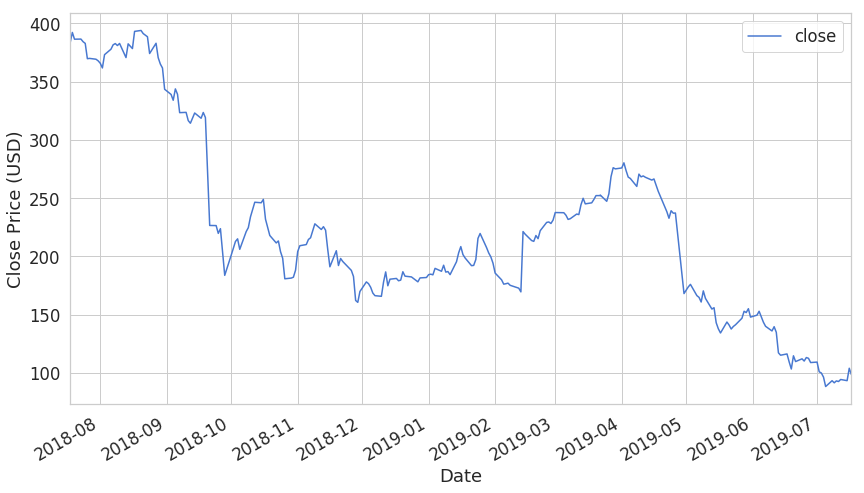

In [17]:
ax = df.plot(x='Date', y="close");
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [0]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [19]:
scaled_close.shape

(246, 1)

In [20]:
np.isnan(scaled_close).any()

False

In [0]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [0]:
scaled_close = scaled_close.reshape(-1, 1)

In [23]:
np.isnan(scaled_close).any()

False

In [0]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [25]:
X_train.shape

(138, 99, 1)

In [26]:
X_test.shape

(8, 99, 1)

In [27]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

W0724 18:02:19.880747 139954982889344 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 18:02:19.889967 139954982889344 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 18:02:19.891188 139954982889344 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with

In [0]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [29]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Train on 124 samples, validate on 14 samples
Epoch 1/50
124/124 [==============================] - 7s 58ms/sample - loss: 0.0991 - val_loss: 0.2008
Epoch 2/50
124/124 [==============================] - 0s 1ms/sample - loss: 0.1288 - val_loss: 0.0203
Epoch 3/50
124/124 [==============================] - 0s 1ms/sample - loss: 0.0328 - val_loss: 0.0027
Epoch 4/50
124/124 [==============================] - 0s 934us/sample - loss: 0.0469 - val_loss: 0.0051
Epoch 5/50
124/124 [==============================] - 0s 882us/sample - loss: 0.0312 - val_loss: 0.0206
Epoch 6/50
124/124 [==============================] - 0s 891us/sample - loss: 0.0137 - val_loss: 0.0546
Epoch 7/50
124/124 [==============================] - 0s 894us/sample - loss: 0.0201 - val_loss: 0.0612
Epoch 8/50
124/124 [==============================] - 0s 887us/sample - loss: 0.0189 - val_loss: 0.0365
Epoch 9/50
124/124 [==============================] - 0s 876us/sample - loss: 0.0114 - val_loss: 0.0199
Epoch 10/50
124/124 [===

In [30]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 4ms/sample - loss: 0.0021


0.0020831949077546597

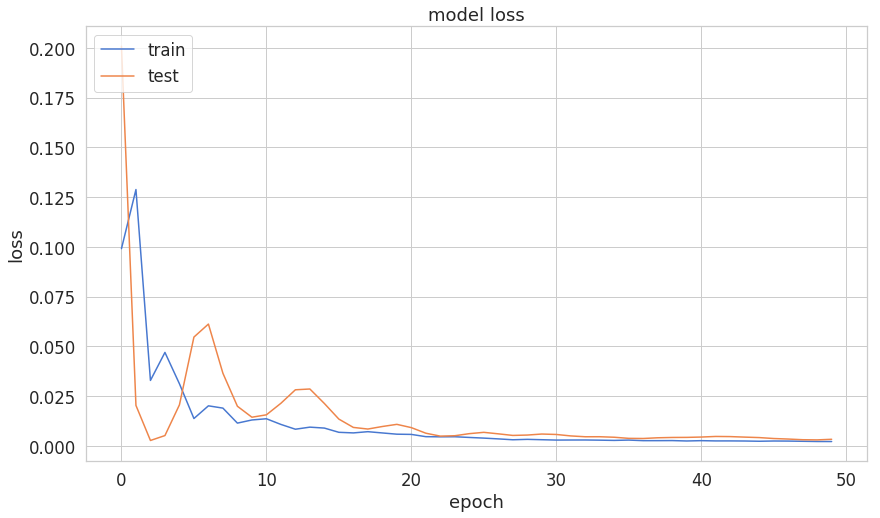

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

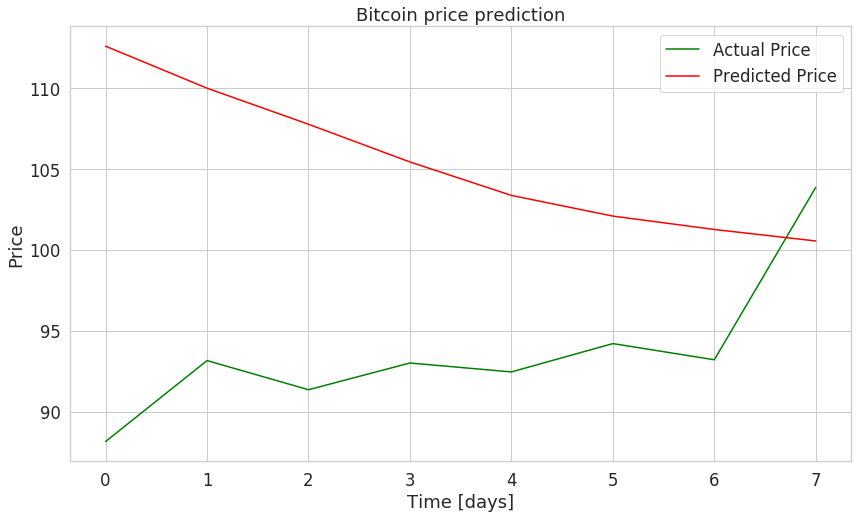

In [32]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();